# Classification and KNN with NHL Data

In this notebook I'll be predicting the rank of NHL teams using the K Nearest Neighbors classifier. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Import data
web_csv = 'https://raw.githubusercontent.com/josephofiowa/GA-DSI/master/NHL_Data_GA.csv'
local_csv = './NHL_Data_GA.csv'

df = pd.read_csv(web_csv)

print(df.shape)
df.head()

(90, 28)


,Team,PTS,Rank,TOI,GF,GA,GF60,GA60,GF%,SF,...,FF%,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM
0,Washington10,121,1,2001:52:00,115,73,3.45,2.19,61.2,1112,...,51.3,2138,1935,64.1,58.0,52.5,10.34,93.03,1034,1269
1,Vancouver11,117,1,2056:14:00,94,72,2.74,2.10,56.6,1143,...,53.1,2144,1870,62.6,54.6,53.4,8.22,93.16,1014,985
2,San Jose10,113,1,1929:54:00,90,68,2.80,2.11,57.0,1065,...,50.9,1985,1876,61.7,58.3,51.4,8.45,93.46,1019,1195
3,Chicago10,112,1,2020:23:00,104,83,3.09,2.46,55.6,1186,...,58.1,2093,1572,62.2,46.7,57.1,8.77,90.44,992,966
4,Vancouver12,111,1,2052:02:00,86,74,2.51,2.16,53.8,1078,...,51.0,2085,1880,61.0,55.0,52.6,7.98,93.36,1013,1049


## EDA

In [14]:
# Set feature matrix and target vector
X = df.drop(['Rank'], axis=1)
y = df['Rank']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1337)

In [15]:
# Check for Nans
print(X_train.isnull().sum())
print(X_train.dtypes)

Team    0
PTS     0
TOI     0
GF      0
GA      0
GF60    0
GA60    0
GF%     0
SF      0
SA      0
SF60    0
SA60    0
SF%     0
FF      0
FA      0
FF60    0
FA60    0
FF%     0
CF      0
CA      0
CF60    0
CA60    0
CF%     0
Sh%     0
Sv%     0
PDO     0
PIM     0
dtype: int64
Team     object
PTS       int64
TOI      object
GF        int64
GA        int64
GF60    float64
GA60    float64
GF%     float64
SF        int64
SA        int64
SF60    float64
SA60    float64
SF%     float64
FF        int64
FA        int64
FF60    float64
FA60    float64
FF%     float64
CF        int64
CA        int64
CF60    float64
CA60    float64
CF%     float64
Sh%     float64
Sv%     float64
PDO       int64
PIM       int64
dtype: object


In [16]:
y_train.value_counts()

3    24
2    22
1    21
Name: Rank, dtype: int64

unique values:  [2 3 1]
baseline accuracy:  0.18


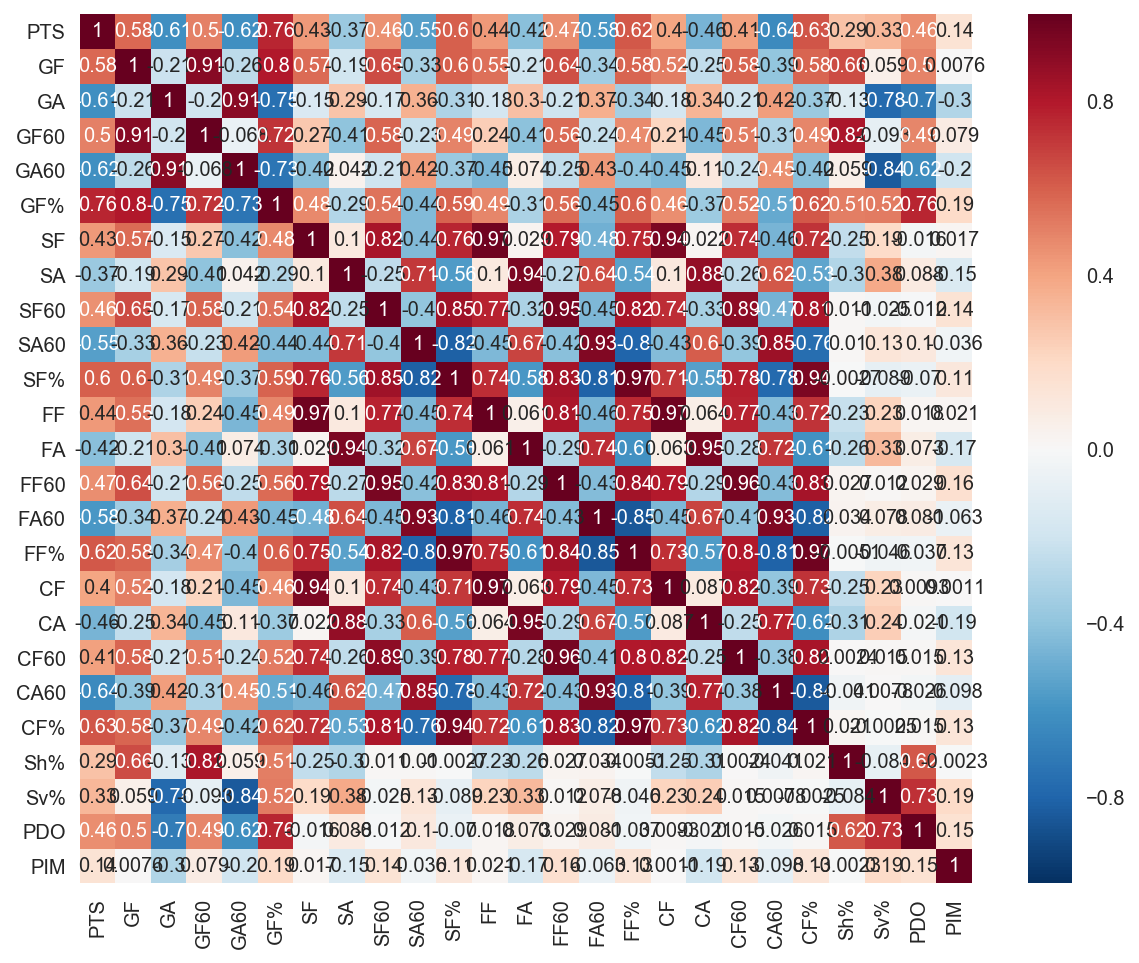

In [17]:
print('unique values: ', y_train.unique())
print('baseline accuracy: ', round(max(y_train.value_counts()/y_train.sum()), 2))

# Check correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), annot=True)

There seems to be a lot of collinearity so we'll keep that in mind. Also there's 3 categories for rank which makes this a multiclassification problem.

In [18]:
# Scale numerical features
X_train_num = X_train.drop(['Team', 'TOI'], axis=1)
X_test_num = X_test.drop(['Team', 'TOI'], axis=1)

ss = StandardScaler()
X_train_num = ss.fit_transform(X_train_num)
X_test_num = ss.transform(X_test_num)

## Modeling

In [19]:
# Run base KNN model with numerical features
knn = KNeighborsClassifier()
knn.fit(X_train_num, y_train)

knn.score(X_test_num, y_test)

0.60869565217391308

60.87% accuracy with a base KNN classifier with minimal feature engineering isn't too bad. We'll try gridsearching a few n neighbors and use the brute force search algorithmm to see if we can get a boost in performance.

In [20]:
param = {
    'n_neighbors': [1, 3, 5, 7, 10],
}

knn = KNeighborsClassifier(algorithm='brute')
gs = GridSearchCV(knn, param)
gs.fit(X_train_num, y_train)

print('Best n_neigbors: ', gs.best_params_)
print('Score: ', gs.score(X_test_num, y_test))

Best n_neigbors:  {'n_neighbors': 1}
Score:  0.739130434783


The base KNeigborsClassifier is set to n neighbors at 5. The grid search found that n neighbors set to 1 yielded better results Let's plot out the accuracy score through a range of n neighbors now to get some more insight

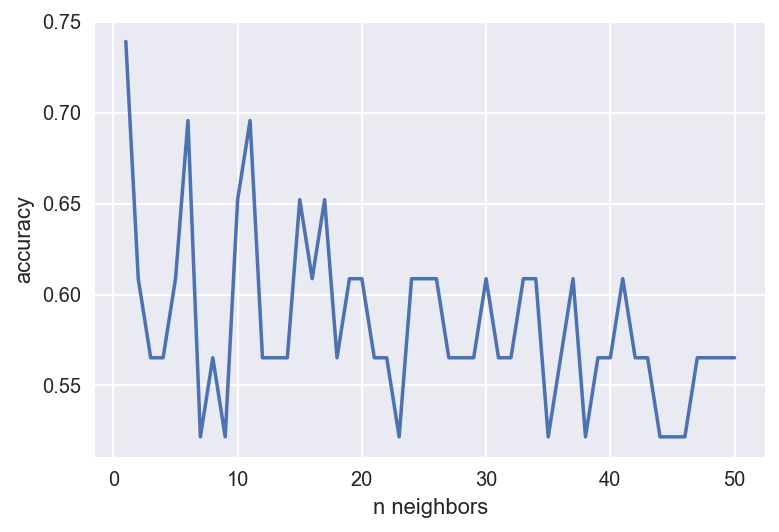

Max Accuracy:  0.739130434783


In [21]:
x_range = range(1, 51)
acc_scores = []

for n in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_num, y_train)
    acc_scores.append(knn.score(X_test_num, y_test))
    
plt.plot(x_range, acc_scores)
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.show()

print('Max Accuracy: ', max(acc_scores))

N neighbors set at 1 yields the best accuracy score. It starts trending negatively as n increases. Let's introduce an ensembling method to see if that yields positive results for our model.

In [22]:
bagged_knn = BaggingClassifier(KNeighborsClassifier())
bagged_knn.fit(X_train_num, y_train)

bagged_knn.score(X_test_num, y_test)

0.65217391304347827

Base bagging classifier isn't providing better results so we'll gridsearch through several parameters.

In [23]:
param = {
    'n_estimators': range(1, 11),
    'max_samples': [5, 7, 9, 11],
    'max_features': [1, 2, 3, 5, 7, 10]
}

bagged_knn = BaggingClassifier(KNeighborsClassifier())

gs = GridSearchCV(bagged_knn, param)
gs.fit(X_train_num, y_train)

gs.score(X_test_num, y_test)

0.52173913043478259

Grid searching the ensembled knn didn't provide better results. As next steps, I'll need to go back to the features and do some feature engineering or try to reduce complexity.